In [ ]:
!pip install -r requirements.txt

In [1]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

# Load in data
gps_data = pd.read_csv('GPS_data.csv')
shipment_bookings = pd.read_csv('Shipment_bookings.csv')
new_bookings = pd.read_csv('New_bookings.csv')

# Task 1:

Operational teams rely heavily on KPIs like on-time collection and on-time delivery to gauge carrier performance. 

What percentage of shipments met the on-time delivery threshold (arriving no later than 30 minutes past the scheduled delivery window) between October 1st and December 31st, 2023? 

Please outline your assumptions.

### Assumptions: 
1. The first and last chronological entry per gps data is the first collection and last delivery of the shipment, respectively. There doesn't appear to be matching latitude and longitude exactly, so we can't match based on these. 
2. We're taking any shipment that had it's FIRST_COLLECTION_SCHEDULE_EARLIEST in the given date range, which appears to be contained in the first data set, and none of the new_bookings. 
3. The data contains the correct shipment and corresponding shipment numbers across the datasets.

### 1.1 Find date range of datasets

In [2]:
earliest_datetime = shipment_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'].min()
latest_datetime = shipment_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'].max()
print("Shipment bookings csv:")
print("Earliest Shipment:", earliest_datetime, "Latest Shipment:", latest_datetime)


Shipment bookings csv:
Earliest Shipment: 2023-09-29T14:00:00.000Z Latest Shipment: 2023-12-31T00:30:00.000Z


In [3]:
earliest_datetime = new_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'].min()
latest_datetime = new_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'].max()
print("New Booking csv:")
print("Earliest Shipment:", earliest_datetime, "Latest Shipment:", latest_datetime)


New Booking csv:
Earliest Shipment: 2024-01-09T12:00:00.000Z Latest Shipment: 2024-01-20T23:45:00.000Z


In [4]:
# Filter to only desired dates
# Ensure the column is in datetime format
shipment_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'] = pd.to_datetime(shipment_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'])

# Define the start of October in the same timezone
start_of_october = pd.Timestamp('2023-10-01', tz='UTC')

# Filter the dataframe to include only dates from October onwards
df = shipment_bookings[shipment_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'] >= start_of_october]

earliest_datetime = df['FIRST_COLLECTION_SCHEDULE_EARLIEST'].min()
latest_datetime = df['FIRST_COLLECTION_SCHEDULE_EARLIEST'].max()
print("New df, from Oct - Dec 2023:")
print("Earliest Shipment:", earliest_datetime, "Latest Shipment:", latest_datetime)

New df, from Oct - Dec 2023:
Earliest Shipment: 2023-10-01 00:30:00+00:00 Latest Shipment: 2023-12-31 00:30:00+00:00


### 1.2 Convert first and last GPS timestamps to collection and delivery times

In [5]:
grouped_gps_data = gps_data.groupby('SHIPMENT_NUMBER')['RECORD_TIMESTAMP'] # group them into order (may not be necessary)

new_gps_data = pd.DataFrame({
    'FIRST_COLLECTION': grouped_gps_data.min(), 
    'LAST_DELIVERY': grouped_gps_data.max()
}).reset_index()

In [6]:
# To visualise what we've created
new_gps_data.head()

,SHIPMENT_NUMBER,FIRST_COLLECTION,LAST_DELIVERY
0,SEZHUK-230918-245388,2023-10-09T19:25:00.000+0100,2023-10-11T11:50:00.000+0100
1,SEZHUK-230919-245487,2023-11-30T11:42:00.000Z,2023-11-30T15:59:00.000Z
2,SEZHUK-230919-245488,2023-10-12T08:38:00.000+0100,2023-10-12T13:08:00.000+0100
3,SEZHUK-230919-245489,2023-11-09T12:21:00.000Z,2023-11-09T17:51:00.000Z
4,SEZHUK-230919-245490,2023-11-02T11:44:00.000Z,2023-11-02T16:29:00.000Z


### 1.3 Merge datasets

In [7]:
# left merge so any SHIPMENT NUMBERS we deleted from outside the Oct-Dec window are excluded.
merged_df = df.merge(new_gps_data, on='SHIPMENT_NUMBER', how='left')

In [8]:
merged_df.head(3)

,PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,FIRST_COLLECTION_SCHEDULE_EARLIEST,FIRST_COLLECTION_SCHEDULE_LATEST,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST,FIRST_COLLECTION,LAST_DELIVERY
0,5456fcfa-5b0c-428e-b322-240d508b6660,SEZHUK-231005-250448,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,PE29 2XR,EH48 2FB,52.315672,-0.157664,55.877803,-3.648558,2023-10-06 09:45:00+00:00,2023-10-06T10:00:00.000Z,2023-10-09T09:55:00.000Z,2023-10-09T10:25:00.000Z,2023-10-06T09:58:00.000+0100,2023-10-06T10:24:00.000+0100
1,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231217-275004,CAUK000660,Tractor Unit,Box 44ft,BD5 8LZ,RG19 4BQ,53.764125,-1.740145,51.398851,-1.231993,2023-12-19 14:20:00+00:00,2023-12-19T16:00:00.000Z,2023-12-20T06:00:00.000Z,2023-12-20T08:56:00.000Z,2023-12-19T15:47:00.000Z,2023-12-20T04:08:00.000Z
2,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231210-272018,CAUK000435,Tractor Unit,Box 44ft,BD5 8LZ,EN3 7QP,53.767302,-1.746560,51.660700,-0.022247,2023-12-14 01:20:00+00:00,2023-12-14T03:00:00.000Z,2023-12-14T07:03:00.000Z,2023-12-14T10:43:00.000Z,2023-12-13T20:51:00.000Z,2023-12-14T10:18:00.000Z


### 1.4 Add 30 minute cutoff window as per the task

In [9]:
# convert the columns to datetime if they're not
merged_df['FIRST_COLLECTION_SCHEDULE_LATEST'] = pd.to_datetime(merged_df['FIRST_COLLECTION_SCHEDULE_LATEST'])
merged_df['LAST_DELIVERY_SCHEDULE_LATEST'] = pd.to_datetime(merged_df['LAST_DELIVERY_SCHEDULE_LATEST'])

# add 30 minutes to the schedule times
merged_df['COLLECTION_CUTOFF'] = merged_df['FIRST_COLLECTION_SCHEDULE_LATEST'] + pd.Timedelta(minutes=30)
merged_df['DELIVERY_CUTOFF'] = merged_df['LAST_DELIVERY_SCHEDULE_LATEST'] + pd.Timedelta(minutes=30)

In [10]:
merged_df.head(3)

,PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,FIRST_COLLECTION_SCHEDULE_EARLIEST,FIRST_COLLECTION_SCHEDULE_LATEST,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST,FIRST_COLLECTION,LAST_DELIVERY,COLLECTION_CUTOFF,DELIVERY_CUTOFF
0,5456fcfa-5b0c-428e-b322-240d508b6660,SEZHUK-231005-250448,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,PE29 2XR,EH48 2FB,52.315672,-0.157664,55.877803,-3.648558,2023-10-06 09:45:00+00:00,2023-10-06 10:00:00+00:00,2023-10-09T09:55:00.000Z,2023-10-09 10:25:00+00:00,2023-10-06T09:58:00.000+0100,2023-10-06T10:24:00.000+0100,2023-10-06 10:30:00+00:00,2023-10-09 10:55:00+00:00
1,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231217-275004,CAUK000660,Tractor Unit,Box 44ft,BD5 8LZ,RG19 4BQ,53.764125,-1.740145,51.398851,-1.231993,2023-12-19 14:20:00+00:00,2023-12-19 16:00:00+00:00,2023-12-20T06:00:00.000Z,2023-12-20 08:56:00+00:00,2023-12-19T15:47:00.000Z,2023-12-20T04:08:00.000Z,2023-12-19 16:30:00+00:00,2023-12-20 09:26:00+00:00
2,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231210-272018,CAUK000435,Tractor Unit,Box 44ft,BD5 8LZ,EN3 7QP,53.767302,-1.746560,51.660700,-0.022247,2023-12-14 01:20:00+00:00,2023-12-14 03:00:00+00:00,2023-12-14T07:03:00.000Z,2023-12-14 10:43:00+00:00,2023-12-13T20:51:00.000Z,2023-12-14T10:18:00.000Z,2023-12-14 03:30:00+00:00,2023-12-14 11:13:00+00:00


### 1.5 Assess lateness 

In [13]:
merged_df['FIRST_COLLECTION'] = pd.to_datetime(merged_df['FIRST_COLLECTION'], errors='coerce')
merged_df['LAST_DELIVERY'] = pd.to_datetime(merged_df['LAST_DELIVERY'], errors='coerce')
merged_df['COLLECTION_CUTOFF'] = pd.to_datetime(merged_df['COLLECTION_CUTOFF'], errors='coerce')
merged_df['DELIVERY_CUTOFF'] = pd.to_datetime(merged_df['DELIVERY_CUTOFF'], errors='coerce')

merged_df['LATE_COLLECTION'] = (merged_df['FIRST_COLLECTION'] > merged_df['COLLECTION_CUTOFF']).astype(int)
merged_df['LATE_DELIVERY'] = (merged_df['LAST_DELIVERY'] > merged_df['DELIVERY_CUTOFF']).astype(int)

merged_df.head(5)


,PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,...,FIRST_COLLECTION_SCHEDULE_EARLIEST,FIRST_COLLECTION_SCHEDULE_LATEST,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST,FIRST_COLLECTION,LAST_DELIVERY,COLLECTION_CUTOFF,DELIVERY_CUTOFF,LATE_COLLECTION,LATE_DELIVERY
0,5456fcfa-5b0c-428e-b322-240d508b6660,SEZHUK-231005-250448,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,PE29 2XR,EH48 2FB,52.315672,-0.157664,55.877803,...,2023-10-06 09:45:00+00:00,2023-10-06 10:00:00+00:00,2023-10-09T09:55:00.000Z,2023-10-09 10:25:00+00:00,2023-10-06 09:58:00+01:00,2023-10-06 10:24:00+01:00,2023-10-06 10:30:00+00:00,2023-10-09 10:55:00+00:00,0,0
1,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231217-275004,CAUK000660,Tractor Unit,Box 44ft,BD5 8LZ,RG19 4BQ,53.764125,-1.740145,51.398851,...,2023-12-19 14:20:00+00:00,2023-12-19 16:00:00+00:00,2023-12-20T06:00:00.000Z,2023-12-20 08:56:00+00:00,2023-12-19 15:47:00+00:00,2023-12-20 04:08:00+00:00,2023-12-19 16:30:00+00:00,2023-12-20 09:26:00+00:00,0,0
2,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231210-272018,CAUK000435,Tractor Unit,Box 44ft,BD5 8LZ,EN3 7QP,53.767302,-1.746560,51.660700,...,2023-12-14 01:20:00+00:00,2023-12-14 03:00:00+00:00,2023-12-14T07:03:00.000Z,2023-12-14 10:43:00+00:00,2023-12-13 20:51:00+00:00,2023-12-14 10:18:00+00:00,2023-12-14 03:30:00+00:00,2023-12-14 11:13:00+00:00,0,0
3,40415fe3-e446-4d1e-b141-3698b0dc47f3,SEZHUK-231211-272127,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,HP22 5BL,NG31 7UH,51.779657,-0.772897,52.888113,...,2023-12-13 09:00:00+00:00,2023-12-13 09:30:00+00:00,2023-12-13T15:30:00.000Z,2023-12-13 16:00:00+00:00,2023-12-13 10:41:00+00:00,2023-12-13 17:22:00+00:00,2023-12-13 10:00:00+00:00,2023-12-13 16:30:00+00:00,1,1
4,39a4e234-5d35-4d94-8e8a-b8bf6fe13953,SEZHUK-231025-256168,CAUK000155,Tractor Unit,Curtain Side,CV23 8BQ,G75 0ZZ,52.334853,-1.180450,55.735089,...,2023-11-07 14:00:00+00:00,2023-11-07 15:00:00+00:00,2023-11-07T23:00:00.000Z,2023-11-07 23:59:00+00:00,2023-11-07 14:17:00+00:00,2023-11-08 03:53:00+00:00,2023-11-07 15:30:00+00:00,2023-11-08 00:29:00+00:00,0,1


In [14]:
percentage_late_collections = merged_df['LATE_COLLECTION'].mean() * 100
percentage_late_deliveries = merged_df['LATE_DELIVERY'].mean() * 100

print(round(percentage_late_collections, 2), "% of collections were late")
print(round(percentage_late_deliveries, 2), "% of deliveries were late")

39.61 % of collections were late
37.36 % of deliveries were late


In [15]:
# the task actually asks for % of on-time, not of late deliveries...
print(100 - round(percentage_late_deliveries, 2), "% of deliveries were on time.")

62.64 % of deliveries were on time.


### Answer: 62.64% of shipments met the on-time delivery threshold (arriving no later than 30 minutes past the scheduled delivery window) between October 1st and December 31st, 2023

# Task 2:

Timely communication of potential delays is crucial for shippers. 

During the 3-month period from 1st Oct to 31st Dec 2023, which shipper(s) should be notified automatically regarding potential late delivery of which shipments, and at what times?

Here, we will assume that potential late delivery is automatically notified is there is a late collection of shipment past the scheduled delivery window + 30 minutes. The shippers should be notified automatically at the time 30 minutes after the scheduled collection window IF the item still has not been collected. (E.g. if the collection window is until 12pm, and the item has not been collected by 12:30pm, then notify the shipper.)

In [16]:
late_col_late_del = merged_df[(merged_df['LATE_COLLECTION'] == 1) & (merged_df['LATE_DELIVERY'] == 1)].shape[0]
late_col_on_time_del =  merged_df[(merged_df['LATE_COLLECTION'] == 1) & (merged_df['LATE_DELIVERY'] == 0)].shape[0]

print("Proportion of late collections that end up with late deliveries:")
round(late_col_late_del / (late_col_late_del + late_col_on_time_del),2)

Proportion of late collections that end up with late deliveries:


0.57

In [17]:
on_time_col_late_del = merged_df[(merged_df['LATE_COLLECTION'] == 0) & (merged_df['LATE_DELIVERY'] == 1)].shape[0]
on_time_on_time_del =  merged_df[(merged_df['LATE_COLLECTION'] == 0) & (merged_df['LATE_DELIVERY'] == 0)].shape[0]

print("Proportion of on time collections that result in late deliveries:")
round(on_time_col_late_del / (on_time_col_late_del+on_time_on_time_del),2)


Proportion of on time collections that result in late deliveries:


0.25

So we know that late collections are much more likely to end up in late deliveries. So lets automatically notify shippers who have a LATE_COLLECTION, at the time of the closing of their collection window + 30 minutes. We can easily extrapolate this data set as we already have all of the data required - the COLLECTION_CUTOFF (which is FIRST_COLLECTION_SCHEDULE_LATEST plus 30 minutes) and the LATE_COLLECTION column, which tells us which shipments had late collections.

Note that the SHIPPER_ID seems to be missing, so we will use shipment number to list which shipments need to be delivered. 

In [18]:
notify_shippers = merged_df[merged_df['LATE_COLLECTION'] == 1][['SHIPMENT_NUMBER','COLLECTION_CUTOFF']]

In [19]:
notify_shippers

,SHIPMENT_NUMBER,COLLECTION_CUTOFF
3,SEZHUK-231211-272127,2023-12-13 10:00:00+00:00
8,SEZHUK-231126-266580,2023-11-27 02:30:01+00:00
10,SEZHUK-230929-248606,2023-10-02 16:29:00+00:00
11,SEZHUK-231102-258924,2023-11-03 17:30:00+00:00
14,SEZHUK-230927-247990,2023-10-04 01:30:00+00:00
...,...,...
3231,SEZHUK-231101-258349,2023-11-02 18:30:00+00:00
3234,SEZHUK-231109-261155,2023-11-21 05:30:00+00:00
3235,SEZHUK-231221-276349,2023-12-22 15:32:00+00:00
3239,SEZHUK-231122-265206,2023-12-02 01:30:00+00:00


The above dataframe shows the shipment numbers that had late collections, and the time we know that the collection was late (30 minutes after the scheduled collection window).

For a larger scope project, one could assess the difference between the GPS location throughout the shippers journey, and use the distance and average velocity of the courier to assess when or if a courier would arrive within the delivery window, or more than 30 minutes afterwards.

## Task 3: 

(Optional): Predict the likelihood of delay for the list of shipments in “New_bookings.csv” dataset.

To do this we can train a model on the variables in the shipment_bookings.csv file. First we will choose the columns of potential interest:


In [20]:
shipment_training_data_whole = merged_df[['CARRIER_DISPLAY_ID', 'VEHICLE_SIZE',
       'VEHICLE_BUILD_UP', 'FIRST_COLLECTION_LATITUDE',
       'FIRST_COLLECTION_LONGITUDE', 'LAST_DELIVERY_LATITUDE',
       'LAST_DELIVERY_LONGITUDE', 'FIRST_COLLECTION_SCHEDULE_EARLIEST',
       'FIRST_COLLECTION_SCHEDULE_LATEST', 'LAST_DELIVERY_SCHEDULE_EARLIEST',
       'LAST_DELIVERY_SCHEDULE_LATEST','LATE_DELIVERY']]

# removing project ID and shipment ID numbers, and post codes which are not as specific as the lat and long columns.
# We are keeping the carrier ID, the vehicle size and build up, and the collection windows and longitude and latitude.
# We can now engineer some more interesting columns.

### 3.1 Distance between start and finish using radians and lat/long:

In [21]:
# first find distance between the collection lat/long and destination lat/long
from math import radians, sin, cos, sqrt, atan2

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6371.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = round(R * c)
    return distance

In [22]:
shipment_training_data_whole['DISTANCE'] = shipment_training_data_whole.apply(lambda row: calculate_distance(row['FIRST_COLLECTION_LATITUDE'], row['FIRST_COLLECTION_LONGITUDE'], 
                                                          row['LAST_DELIVERY_LATITUDE'], row['LAST_DELIVERY_LONGITUDE']), axis=1)

### 3.2 Look at day of the week and rush hours as a column:

The dt.hour attribute extracts the hour of the day (in 24-hour format) and dt.dayofweek attribute extracts the day of the week (Monday=0, Sunday=6).

We are setting rush hours to 7:00 - 10:00 and 16:00 - 19:00. 

In [23]:
# convert to datetime if they're not
shipment_training_data_whole['FIRST_COLLECTION_SCHEDULE_EARLIEST'] = pd.to_datetime(shipment_training_data_whole['FIRST_COLLECTION_SCHEDULE_EARLIEST'])
shipment_training_data_whole['LAST_DELIVERY_SCHEDULE_LATEST'] = pd.to_datetime(shipment_training_data_whole['LAST_DELIVERY_SCHEDULE_LATEST'])

# extract hour of day and day of week
shipment_training_data_whole['COLLECTION_HOUR'] = shipment_training_data_whole['FIRST_COLLECTION_SCHEDULE_EARLIEST'].dt.hour
shipment_training_data_whole['DELIVERY_HOUR'] = shipment_training_data_whole['LAST_DELIVERY_SCHEDULE_LATEST'].dt.hour
shipment_training_data_whole['COLLECTION_DAY_OF_WEEK'] = shipment_training_data_whole['FIRST_COLLECTION_SCHEDULE_EARLIEST'].dt.dayofweek
shipment_training_data_whole['DELIVERY_DAY_OF_WEEK'] = shipment_training_data_whole['LAST_DELIVERY_SCHEDULE_LATEST'].dt.dayofweek

In [24]:
shipment_training_data_whole['COLLECTION_RUSH_HOUR'] = ((shipment_training_data_whole['COLLECTION_HOUR'] >= 7) & (shipment_training_data_whole['COLLECTION_HOUR'] <= 10)) | ((shipment_training_data_whole['COLLECTION_HOUR'] >= 16) & (shipment_training_data_whole['COLLECTION_HOUR'] <= 19))
shipment_training_data_whole['DELIVERY_RUSH_HOUR'] = ((shipment_training_data_whole['DELIVERY_HOUR'] >= 7) & (shipment_training_data_whole['DELIVERY_HOUR'] <= 10)) | ((shipment_training_data_whole['DELIVERY_HOUR'] >= 16) & (shipment_training_data_whole['DELIVERY_HOUR'] <= 19))

In [25]:
cols_of_interest = shipment_training_data_whole[[
                                                 'DISTANCE', 'COLLECTION_HOUR', 'DELIVERY_HOUR', 'COLLECTION_DAY_OF_WEEK',
                                                 'DELIVERY_DAY_OF_WEEK', 'COLLECTION_RUSH_HOUR', 'DELIVERY_RUSH_HOUR', 'LATE_DELIVERY']]

### 3.3 Build a model for these columns

In [26]:
X = cols_of_interest.drop(columns=['LATE_DELIVERY'])
y = cols_of_interest['LATE_DELIVERY']

In [27]:
# create dummy variables
# X_encoded = pd.get_dummies(X, columns=['VEHICLE_SIZE', 'VEHICLE_BUILD_UP']) # no longer usng dummmy variables as they don't exist in both sets of data

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = RandomForestClassifier(random_state=42)

# Feature 1. Distance between start and end points

This was the most important feature according to our feature importance scores. Surprisingly, it seems that there are more on time deliveries over 500 KM than late deliveries, shown by the slightly wider violin plot top. There seems to be a peak around 100 KM and 200 KM for lateness, which isn't seen on the on time deliveries. The pattern in lateness is not linear, hence linear regression would not be a suitable fit for this model.

In [28]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6861538461538461


# Task 4: Predict for New Bookings

In [30]:
# recreate column with matching name of cols
# becomes redundant as we don't have matching courier names in both sets of data
new_bookings['CARRIER_DISPLAY_ID'] = new_bookings['CARRIER_ID']

In [31]:
new_data_whole = new_bookings[[
       # 'CARRIER_DISPLAY_ID', 'VEHICLE_SIZE', 'VEHICLE_BUILD_UP', 
       'FIRST_COLLECTION_LATITUDE',
       'FIRST_COLLECTION_LONGITUDE', 'LAST_DELIVERY_LATITUDE',
       'LAST_DELIVERY_LONGITUDE', 'FIRST_COLLECTION_SCHEDULE_EARLIEST',
       'FIRST_COLLECTION_SCHEDULE_LATEST', 'LAST_DELIVERY_SCHEDULE_EARLIEST',
       'LAST_DELIVERY_SCHEDULE_LATEST']]

In [32]:
new_data_whole['DISTANCE'] = new_data_whole.apply(lambda row: calculate_distance(row['FIRST_COLLECTION_LATITUDE'], row['FIRST_COLLECTION_LONGITUDE'], 
                                                          row['LAST_DELIVERY_LATITUDE'], row['LAST_DELIVERY_LONGITUDE']), axis=1)

# convert to datetime if they're not
new_data_whole['FIRST_COLLECTION_SCHEDULE_EARLIEST'] = pd.to_datetime(new_data_whole['FIRST_COLLECTION_SCHEDULE_EARLIEST'])
new_data_whole['LAST_DELIVERY_SCHEDULE_LATEST'] = pd.to_datetime(new_data_whole['LAST_DELIVERY_SCHEDULE_LATEST'])

# extract hour of day and day of week
new_data_whole['COLLECTION_HOUR'] = new_data_whole['FIRST_COLLECTION_SCHEDULE_EARLIEST'].dt.hour
new_data_whole['DELIVERY_HOUR'] = new_data_whole['LAST_DELIVERY_SCHEDULE_LATEST'].dt.hour
new_data_whole['COLLECTION_DAY_OF_WEEK'] = new_data_whole['FIRST_COLLECTION_SCHEDULE_EARLIEST'].dt.dayofweek
new_data_whole['DELIVERY_DAY_OF_WEEK'] = new_data_whole['LAST_DELIVERY_SCHEDULE_LATEST'].dt.dayofweek

new_data_whole['COLLECTION_RUSH_HOUR'] = ((new_data_whole['COLLECTION_HOUR'] >= 7) & (new_data_whole['COLLECTION_HOUR'] <= 10)) | ((new_data_whole['COLLECTION_HOUR'] >= 16) & (new_data_whole['COLLECTION_HOUR'] <= 19))
new_data_whole['DELIVERY_RUSH_HOUR'] = ((new_data_whole['DELIVERY_HOUR'] >= 7) & (new_data_whole['DELIVERY_HOUR'] <= 10)) | ((new_data_whole['DELIVERY_HOUR'] >= 16) & (new_data_whole['DELIVERY_HOUR'] <= 19))

test_cols_of_interest = new_data_whole[['DISTANCE', 'COLLECTION_HOUR', 'DELIVERY_HOUR', 'COLLECTION_DAY_OF_WEEK',
                                                 'DELIVERY_DAY_OF_WEEK', 'COLLECTION_RUSH_HOUR', 'DELIVERY_RUSH_HOUR']]

# encode as before
# test_cols_of_interest_encoded = pd.get_dummies(test_cols_of_interest, columns=['VEHICLE_SIZE', 'VEHICLE_BUILD_UP'])


In [33]:
test_cols_of_interest['LATE_DELIVERY'] = model.predict_proba(test_cols_of_interest)[:, 1]

In [34]:
test_cols_of_interest

,DISTANCE,COLLECTION_HOUR,DELIVERY_HOUR,COLLECTION_DAY_OF_WEEK,DELIVERY_DAY_OF_WEEK,COLLECTION_RUSH_HOUR,DELIVERY_RUSH_HOUR,LATE_DELIVERY
0,345,18,13,3,4,True,False,0.340000
1,322,10,8,4,1,True,True,0.542857
2,345,15,15,3,4,False,False,0.176786
3,357,6,11,1,3,False,False,0.099524
4,352,6,7,3,0,False,True,0.495143
...,...,...,...,...,...,...,...,...
995,25,9,14,4,4,True,False,0.302952
996,134,8,14,4,4,True,False,0.641333
997,198,12,19,2,2,False,True,0.944000
998,383,16,23,2,2,True,False,0.861103


# Examining Feature importance:

The most crucial feature determining the delivery delay is the 'DISTANCE', accounting for approximately 38.66% of the decision-making process. This indicates that the greater the distance between the collection and delivery points, the higher the chances of the delivery being delayed. In the second and third ranks, we have 'DELIVERY_HOUR' and 'COLLECTION_HOUR', contributing to 19.15% and 18.90% of the importance, respectively. These suggest that the timing of collection and delivery plays a significant role in whether the delivery will be on schedule. 

The day of the week for both collection and delivery ('COLLECTION_DAY_OF_WEEK' and 'DELIVERY_DAY_OF_WEEK') also have substantial importance, each accounting for around 9.6% of the model's decision. Lastly, whether the collection or delivery falls within rush hour ('COLLECTION_RUSH_HOUR' and 'DELIVERY_RUSH_HOUR') has the least influence, with each contributing to approximately 2% of the model's decision.

In [35]:
# Assuming you have a trained model named 'model'
importances = model.feature_importances_

# To make it easier to understand, you can create a DataFrame that matches the importances with their corresponding feature names:
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort the DataFrame to see the features with the highest importance at the top:
feature_importances = feature_importances.sort_values('importance', ascending=False)

print(feature_importances)

                  feature  importance
0                DISTANCE    0.386560
2           DELIVERY_HOUR    0.191511
1         COLLECTION_HOUR    0.188966
4    DELIVERY_DAY_OF_WEEK    0.096916
3  COLLECTION_DAY_OF_WEEK    0.096297
6      DELIVERY_RUSH_HOUR    0.020509
5    COLLECTION_RUSH_HOUR    0.019240


# Feature 1. Distance between start and end points

This was the most important feature according to our feature importance scores. Surprisingly, it seems that there are more on time deliveries over 500 KM than late deliveries, shown by the slightly wider violin plot top. There seems to be a peak around 100 KM and 200 KM for lateness, which isn't seen on the on time deliveries. The pattern in lateness is not linear, hence linear regression would not be a suitable fit for this model.

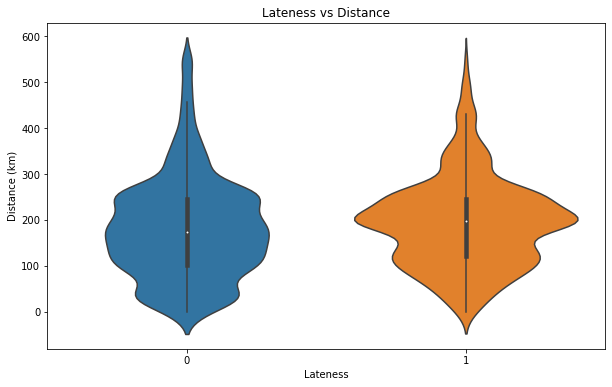

In [47]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='LATE_DELIVERY', y='DISTANCE', data=cols_of_interest)
plt.title('Lateness vs Distance')
plt.xlabel('Lateness')
plt.ylabel('Distance (km)')
plt.show()


## Feature 2. Delivery Hour

The below graphs show firstly that the highest chance of a Late Delivery comes around 11pm-1am, and another peak at 2pm. Surprisingly, the lateness of delivery is least frequent at 9pm delivery hour, just after rush hour. 

The second graph shows a partial dependence plot. A PDP shows the marginal effect of a feature (delivery hour) on the predicted outcome (a late delivery). 
- At 12am-1am, the likelihood of being late is 0.44 higher than at the baseline (which seems to be 22:00).
- This likelihood decreases as the day goes on.
- By 22:00, the likelihood is zero - it's the same as the baseline. This means that the likelihood of being late doesn't increase or decrease at 22:00 compared to the baseline.

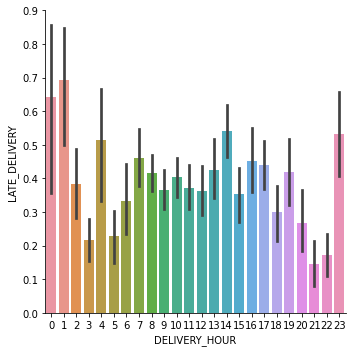

In [44]:
# From the training data
sns.catplot(x="DELIVERY_HOUR", y="LATE_DELIVERY", kind="bar", data=cols_of_interest)
plt.show()

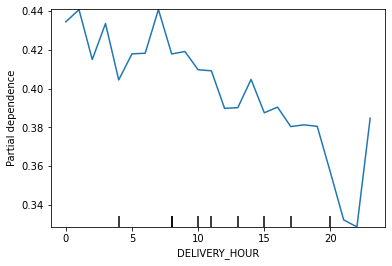

In [43]:
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(model, X_train, ['DELIVERY_HOUR'])
plt.show()

# Feature 3. Collection Hour

Conversely, the deliveries are most likely to be late when the collection is around 8pm to midnight. There is then a significant drop off after midnight, with 12am-4am collections resulting in the lowest incidence of lateness. 

The PDP below shows:
- Late Night to Early Morning (12 AM - 4 AM): The likelihood of late delivery starts at a moderately high level around 0.3 at midnight and gradually drops to its lowest point at 4 AM. This could be due to less traffic and fewer operational constraints at night, which allows for smoother and more efficient collections and subsequent deliveries.


- Morning to Afternoon (4 AM - 5 PM): There is a slight increase in the probability of late delivery around 9 AM, where it reaches approximately 0.425. This elevation might be due to increased traffic and business activities during the morning rush hour. However, this risk gradually decreases again until 5 PM, suggesting that as the day progresses and the morning rush subsides, the efficiency of the collection and delivery process improves.


- Evening to Night (5 PM - 11 PM): From 5 PM onwards, there is a significant increase in the likelihood of late delivery, peaking at around 0.525 between 8 PM and 11 PM. This could be attributed to the evening rush hour, increased traffic, and potentially longer processing times at collection points due to high demand. It's also possible that fatigue and staffing issues play a role during these hours.

In summary, the collection hour significantly impacts the probability of a late delivery, with the lowest likelihood in the early morning hours and the highest in the late evening. Adjustments in operational strategies or staffing during these high-risk periods might help to improve on-time delivery performance.

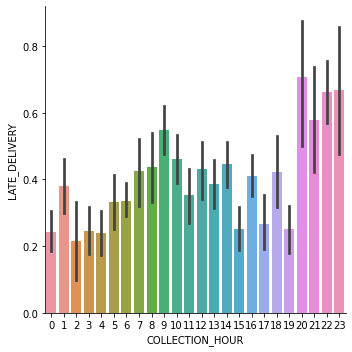

In [51]:
# From the training data
sns.catplot(x="COLLECTION_HOUR", y="LATE_DELIVERY", kind="bar", data=cols_of_interest)
plt.show()

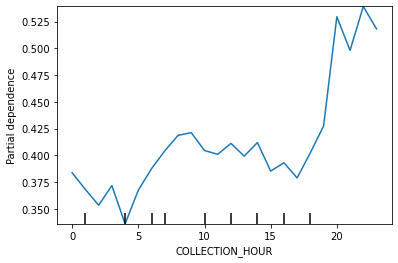

In [52]:
plot_partial_dependence(model, X_train, ['COLLECTION_HOUR'])
plt.show()

# Feature 4. Delivery Day of the Week

This shows that, while there isn't a huge difference in days of the week, Tuesday is the delivery day with least lateness, while Friday and Saturday have the highest, likely due to weekend traffic.

In [70]:
# Group by 'DELIVERY_DAY_OF_WEEK' and calculate the mean of 'LATE_DELIVERY'
percentage_late_by_day = cols_of_interest.groupby('DELIVERY_DAY_OF_WEEK')['LATE_DELIVERY'].mean()

# Convert to percentage
percentage_late_by_day = round(percentage_late_by_day * 100,2)

# set index
days_of_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Assuming "series" is your pandas Series
percentage_late_by_day.index = percentage_late_by_day.index.to_series().replace(days_of_week)
percentage_late_by_day

DELIVERY_DAY_OF_WEEK
Monday       38.21
Tuesday      35.35
Wednesday    36.41
Thursday     36.78
Friday       39.78
Saturday     38.75
Sunday       36.00
Name: LATE_DELIVERY, dtype: float64

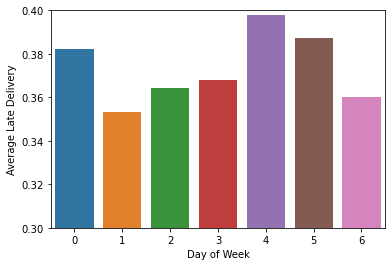

In [77]:
sns.barplot(x='DELIVERY_DAY_OF_WEEK', y='LATE_DELIVERY', data=cols_of_interest, ci=None)
plt.xlabel('Day of Week')
plt.ylabel('Average Late Delivery')
plt.ylim(0.3,0.4) # limit to 10% in which all are contained
plt.show()

# Feature 5. Collection Day of the Week

Collection date has a different level in lateness. Saturday collections are some of the lowest levels of lateness, and Sunday some of the highest (as they lead into the busy start of the week perhaps?)

In [78]:
# Group by 'COLLECTION_DAY_OF_WEEK' and calculate the mean of 'LATE_DELIVERY'
percentage_late_collection_day = cols_of_interest.groupby('COLLECTION_DAY_OF_WEEK')['LATE_DELIVERY'].mean()

# Convert to percentage
percentage_late_collection_day = round(percentage_late_collection_day * 100,2)

# set index
days_of_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Assuming "series" is your pandas Series
percentage_late_collection_day.index = percentage_late_collection_day.index.to_series().replace(days_of_week)
percentage_late_collection_day

COLLECTION_DAY_OF_WEEK
Monday       37.52
Tuesday      39.31
Wednesday    35.74
Thursday     38.15
Friday       36.86
Saturday     34.95
Sunday       38.13
Name: LATE_DELIVERY, dtype: float64

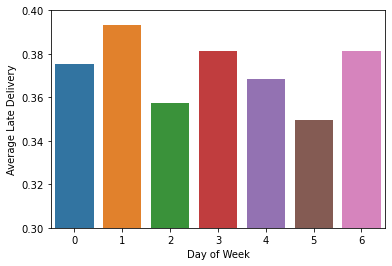

In [79]:
sns.barplot(x='COLLECTION_DAY_OF_WEEK', y='LATE_DELIVERY', data=cols_of_interest, ci=None)
plt.xlabel('Day of Week')
plt.ylabel('Average Late Delivery')
plt.ylim(0.3,0.4) # limit to 10% in which all are contained
plt.show()

# Bonus Points:

### a. Google Best Code Practices have been employed where appropriate.

### b. Technical Design for deploying prediction model through an online endpoint:
    
Here's a high-level outline of the technical design:

1. Model Serialization: Once the model is trained and validated, we need to serialize the model into a format that can be stored and loaded easily. In Python, we can use libraries like pickle or joblib to do this.

e.g.:
```
import joblib
joblib.dump(your_model, 'model.pkl')
```

2. Building a Web Service: Create a web service that can receive API requests, load the serialized model, run the prediction, and return the results. This can be done using web frameworks like Flask or Django in Python. The endpoint could accept shipment details and return a prediction of whether the shipment will be late.

```
from flask import Flask, request
import joblib

app = Flask(__name__)
model = joblib.load('shipment_model.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    prediction = model.predict(data)
    return {'late_shipment_prediction': prediction.tolist()}

if __name__ == '__main__':
    app.run(port=5000)

```
3. Containerization: For easier deployment and scalability, We can containerize our application using Docker. This involves writing a Dockerfile that specifies the base image, dependencies, and commands to run our application.

4. Deployment: Deploy the container to a cloud service provider. We can use services like AWS Elastic Beanstalk, Google Cloud Run, or Azure App Service. These services can automatically manage, scale, and load balance our application.

5. Testing: Once deployed, test the endpoint with sample shipment data to ensure it's working as expected.

6. Monitoring and Updating: After deployment, the model needs to be monitored to ensure it's performing as expected. If the model's performance drops, or if there's new data available, the model might need to be retrained and the web service updated.

This system would allow the haulier company to easily get predictions on whether shipments will be late, helping them better manage their operations and communicate with their customers.

### c. Utilise additional data sources by making API calls.

Ideas:
- Weather data to show historical weather data for collection and delivery post codes. OpenWeatherMap: (https://openweathermap.org/api)
- Traffic data (WebTRIS API: This free API provides traffic data for the UK motorway network, including incidents, roadworks, and average speeds. [WebTRIS API highways england ON webtris.highwaysengland.co.uk])
- Population density info to show if a postcode is urban or rural and therefore could affect traffic and speed of deliveries. OpenStreetMap Nominatim API: (https://nominatim.org/release-docs/latest/api/Overview/)